----

#**MODEL 04**

- Transformer architecture with word embeddings trained in assignment
2 and using merged dataset of all the group members.

### **IMPORTING LIBRARIES**

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import nltk
!pip install nltk rouge-score
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=045f3469ce3ab8fd1cc78045e462f3c3a40db50dbb48c374a6f16ac207228118
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


---

### **LOADING CORPUS (COMBINE TEXTUAL DATA OF ALL GROUP MEMBERS)**

In [2]:
# Reading corpus
with open('/content/cleaned_dataset.txt', 'r') as file:
    corpus = file.readlines()


---

### **TOKENIZATION AND LOWER-CASING**

In [3]:
# Tokenizing sentences
tokenized_corpus = [sentence.split() for sentence in corpus]

# Lower casing
tokenized_corpus = [[word.lower() for word in sentence] for sentence in tokenized_corpus]

---

### **TRAINING WORD2VEC MODEL FOR GENERATING EMBEDDINGS- SAME AS USED IN ASSIGNMENT 02**

In [4]:
# Training Word2Vec for generating embedding
model = Word2Vec(sentences=tokenized_corpus, vector_size=75, window=5, min_count=1, sg=1)

# Saving embeddings with words
with open('word2vec_embeddings.txt', 'w') as f:
    for word in model.wv.index_to_key:
        embedding = model.wv[word]
        embedding_str = ' '.join(map(str, embedding))
        f.write(f"{word} {embedding_str}\n")

---

### **VERIFYING THE MATCHING OF VOCABULARY SIZE AND EMBEDDING**

In [7]:
# Checking the size of the vocabulary and the embeddings
vocabulary_size = len(model.wv.index_to_key)  # Number of unique words in the vocabulary
embedding_size = len(model.wv)  # Number of embeddings generated by the model

print(f"Vocabulary Size: {vocabulary_size}")
print(f"Embedding Size: {embedding_size}")

# Verifying if they match
if vocabulary_size == embedding_size:
    print("The number of embeddings matches the vocabulary size.")
else:
    print("Mismatch: Number of embeddings does not match the vocabulary size.")

Vocabulary Size: 2353
Embedding Size: 2353
The number of embeddings matches the vocabulary size.


---

### **LOADING THE EMBEDDING FILE**

In [8]:
# Loading embeddings

def load_word2vec_embeddings(embedding_file):
    embeddings_index = {}
    with open(embedding_file, 'r') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

embedding_file = '/content/word2vec_embeddings.txt'
embeddings_index = load_word2vec_embeddings(embedding_file)


---
### **INITIALIZING THE TOKENIZER**
- For converting the text data into numerical tokens that can be processed by model.

In [10]:
# Tokenizer and sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)  # Creating sequences
sequences = tokenizer.texts_to_sequences(corpus)


---
### **CREATING SEQUENCES**

- Converting each document/sentence into a sequence of integers based on the word_index
-  Ensuring that all sequences have the same length for uniform input size
- max_sequence_length: Computes the length of the longest sequence in sequences. This determines the length to which all sequences will be padded.
- pad_sequences: Adds padding to shorter sequences so they match the max_sequence_length.

In [11]:
# Padding sequences
max_sequence_length = max(len(seq) for seq in sequences)  # Longest sentence
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')


# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for padding token

---

## **INITIALIZING EMBEDDING MATRIX**

- Embedding Matrix will maps words in our vocabulary to their embeddings. These embeddings will be used as input to our model later on.

In [12]:
# Initializing the embedding matrix
embedding_dim = 75  # From Word2Vec
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Filling the embedding matrix
for word, idx in tokenizer.word_index.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]
    else:
        embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))  # Random vector for missing words


---

## **SPLITTING THE CORPUS (PADDED SEQUENCES) INTO TRAINING AND TESTING DATA**

In [13]:
x = padded_sequences[:, :-1]
y = padded_sequences[:, 1:]

# Splitting the data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


---
## **BUILDING TRANSFOMER ARCHITECTURE**

In [14]:
# Learning rate schedule
initial_learning_rate = 0.005
lr_schedule = ExponentialDecay(
    initial_learning_rate,    # Starting learning rate
    decay_steps=20000,        # Steps after which decay is applied
    decay_rate=0.85,          # Rate at which learning rate is decayed
    staircase=True            # If True, the learning rate decays in a staircase manner
)



# Transformer model parameters
d_model = 75                 # Dimension of the embedding vectors
num_heads = 8                # Number of attention heads in the multi-head attention mechanism
dff = 128                    # Number of neurons in the feedforward network
dropout_rate = 0.1           # Dropout rate to prevent overfitting
num_layers = 4               # Number of Transformer encoder layers




# Input layer for the sequences
input_seq = Input(shape=(max_sequence_length - 1,))



# Embedding layer
embedding_layer = Embedding(
    input_dim=vocab_size,     # Vocabulary size
    output_dim=d_model,       # Dimension of each embedding vector
    weights=[embedding_matrix],  # Pretrained embedding matrix
    trainable=False           # Freezes the embeddings
)(input_seq)




# Encoder layers
x = embedding_layer
for i in range(num_layers):
    attn_output = MultiHeadAttention(
        num_heads=num_heads,  # Number of attention heads
        key_dim=d_model       # Dimension of the key vectors
    )(x, x)

    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = LayerNormalization()(x + attn_output)

    ffn_output = Dense(dff, activation='relu')(attn_output)
    ffn_output = Dense(d_model)(ffn_output)

    ffn_output = Dropout(dropout_rate)(ffn_output)
    x = LayerNormalization()(attn_output + ffn_output)




# Output layer
output = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=input_seq, outputs=output)







---
## **TRAINING THE MODEL**

In [15]:
# Compilng model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1362)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1362, 75)       │        167,700 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1362, 75)       │        181,875 │ embedding[0][0],       │
│ (MultiHeadAttention)      │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1362, 75)       │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1362, 75)       │              0 │ embedding[0][0],       │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 1362, 75)       │            150 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1362, 128)      │          9,728 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1362, 75)       │          9,675 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1362, 75)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1362, 75)       │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 1362, 75)       │            150 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 1362, 75)       │        181,875 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1362, 75)       │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1362, 75)       │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 1362, 75)       │            150 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)      

 Total params: 1,143,948 (4.36 MB)

 Trainable params: 976,248 (3.72 MB)

 Non-trainable params: 167,700 (655.08 KB)

In [16]:
# Training model


model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=15)

Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 70s 16s/step - accuracy: 0.7589 - loss: 6.8717 - val_accuracy: 0.9082 - val_loss: 4.4745
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9276 - loss: 4.1965 - val_accuracy: 0.9082 - val_loss: 2.7415
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9355 - loss: 2.4447 - val_accuracy: 0.9082 - val_loss: 1.3256
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9352 - loss: 1.1022 - val_accuracy: 0.9082 - val_loss: 0.9309
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9320 - loss: 0.7210 - val_accuracy: 0.9082 - val_loss: 0.9854
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9267 - loss: 0.7784 - val_accuracy: 0.9082 - val_loss: 1.0592
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9249 - loss: 0.8445 - val_accuracy: 0.9082 - val_loss: 1.0890
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9300 - loss: 0.7989 - val_accuracy: 0.9082 - val_loss: 1.0610
Epoch 9/15
3/3

---

## **TRANSFORMER DECODER**

In [17]:
# Creating Function to generate predictions for a list of sequences

def generate_predictions(model, tokenizer, sequences, max_sequence_length):
    predictions = []  # List to store predictions
    for seq in sequences:

        # Preparing the input sequence, ensuring it's the correct shape for the model
        input_seq = seq[:max_sequence_length - 1].reshape(1, -1)  # Taking up to max_sequence_length - 1 tokens and reshaping

        pred_probs = model.predict(input_seq, verbose=0)  # Predicting probabilities for the next word

        # Mapping predicted indices to words using the tokenizer's index-to-word mapping
        pred_words = [tokenizer.index_word.get(idx, '') for idx in pred_probs.argmax(axis=-1)[0]]
        predictions.append(pred_words)  # Appending the predicted words to the list
    return predictions

In [18]:
# Creating Function to generate actual words from sequences

def generate_actuals(sequences, tokenizer):
    actuals = []  # List to store actual sequences in word form
    for seq in sequences:
        # Converting sequence indices to words
        words = [tokenizer.index_word.get(idx, '') for idx in seq]
        actuals.append(words)  # Append the actual words to the list
    return actuals

In [19]:
# Generating  predicted sequences for evaluation
predicted_sequences = generate_predictions(model, tokenizer, x_val, max_sequence_length)


# Generating actual sequences from the ground truth
actual_sequences = generate_actuals(y_val, tokenizer)


---
## **MODEL EVALUATION ON BLEU AND ROUGHE**

In [20]:
# Computing BLEU scores for the predicted and actual sequences
smooth_fn = SmoothingFunction().method1  # Smoothing function for BLEU scores

# Computing BLEU score for each sentence pair
bleu_scores = [sentence_bleu([actual], pred, smoothing_function=smooth_fn)
               for actual, pred in zip(actual_sequences, predicted_sequences)]
# Compute corpus-level BLEU scores with different n-gram weights
bleu_1 = corpus_bleu([[a] for a in actual_sequences], predicted_sequences, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu([[a] for a in actual_sequences], predicted_sequences, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu([[a] for a in actual_sequences], predicted_sequences, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu([[a] for a in actual_sequences], predicted_sequences, weights=(0.25, 0.25, 0.25, 0.25))

# Printing BLEU scores
print("BLEU Scores:")
print(f"BLEU-1: {bleu_1:.4f}")
print(f"BLEU-2: {bleu_2:.4f}")
print(f"BLEU-3: {bleu_3:.4f}")
print(f"BLEU-4: {bleu_4:.4f}")







# Computing ROUGE scores using a scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
# Initialize cumulative ROUGE scores with offsets for clarity
rouge_1, rouge_2, rouge_l = 0, 0, 0



# Iterate over actual and predicted sequences
for actual, pred in zip(actual_sequences, predicted_sequences):
    # Converting sequences to strings for scoring
    actual_str = ' '.join(actual)
    pred_str = ' '.join(pred)
    # Computing ROUGE scores for the pair
    scores = scorer.score(actual_str, pred_str)
    rouge_1 += scores['rouge1'].fmeasure  # Accumulate ROUGE-1 F1 scores
    rouge_2 += scores['rouge2'].fmeasure  # Accumulate ROUGE-2 F1 scores
    rouge_l += scores['rougeL'].fmeasure  # Accumulate ROUGE-L F1 scores



# Averaging ROUGE scores over all sequences
n = len(actual_sequences)
print("\n ROUGE Scores:")
print(f"ROUGE-1 (F1): {rouge_1 / n:.4f}")
print(f"ROUGE-2 (F1): {rouge_2 / n:.4f}")
print(f"ROUGE-L (F1): {rouge_l / n:.4f}")


BLEU Scores:
BLEU-1: 0.9082
BLEU-2: 0.9082
BLEU-3: 0.9090
BLEU-4: 0.9081

 ROUGE Scores:
ROUGE-1 (F1): 0.4250
ROUGE-2 (F1): 0.4550
ROUGE-L (F1): 0.5250


---
---

#  **4×  MODEL 4 CHECK POINTS**

#### **Checkpoint 1: After Training Word2Vec Model**

In [29]:
# Checkpoint 1: After Training Word2Vec Model

# SavING Keras Transformer model checkpoint
model.save('word2vec_model_checkpoint.keras')

In [30]:
from google.colab import files

files.download('word2vec_model_checkpoint.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Checkpoint 2: After Initializing the Embedding Matrix**

In [23]:
# Save embedding matrix checkpoint
np.save('embedding_matrix_checkpoint.npy', embedding_matrix)


#### **Checkpoint 3: After Each Training Epoch**


In [25]:
# Defining a checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_epoch_{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_best_only=False
)

# Adding the callback in model training
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=15, callbacks=[checkpoint_callback])

Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9274 - loss: 0.7229 - val_accuracy: 0.9082 - val_loss: 0.9315
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9345 - loss: 0.6579 - val_accuracy: 0.9082 - val_loss: 0.9356
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9234 - loss: 0.7562 - val_accuracy: 0.9082 - val_loss: 0.9339
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9371 - loss: 0.6337 - val_accuracy: 0.9082 - val_loss: 0.9360
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9315 - loss: 0.6813 - val_accuracy: 0.9082 - val_loss: 0.9290
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9250 - loss: 0.7401 - val_accuracy: 0.9082 - val_loss: 0.9296
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9292 - loss: 0.7026 - val_accuracy: 0.9082 - val_loss: 0.9441
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9227 - loss: 0.7604 - val_accuracy: 0.9082 - val_loss: 0.9509
Epoch 9/15
3/3 ━

In [32]:
import os

epoch = 15
filename = f'model_checkpoint_epoch_{epoch:02d}.weights.h5'

if os.path.exists(filename):
    files.download(filename)
else:
    print(f"Error: File '{filename}' not found.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
#### **Checkpoint 4: Best Performing Model**

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
    save_weights_only=True
)

# Fit the model with the checkpoint callback, using x_train and y_train
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    callbacks=[checkpoint]
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9314 - loss: 0.6854
Epoch 1: val_loss improved from inf to 0.94269, saving model to best_model.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9310 - loss: 0.6881 - val_accuracy: 0.9082 - val_loss: 0.9427
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9414 - loss: 0.5950
Epoch 2: val_loss did not improve from 0.94269
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9385 - loss: 0.6202 - val_accuracy: 0.9082 - val_loss: 0.9553
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9310 - loss: 0.6834
Epoch 3: val_loss did not improve from 0.94269
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9308 - loss: 0.6861 - val_accuracy: 0.9082 - val_loss: 0.9529
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9269 - loss: 0.7177
Epoch 4: val_loss did not improve from 0.94269
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9277 - loss: 0.7116 - val_accuracy: 0.9082 - val_loss: 0.9481
E

In [41]:
# Downloading

files.download('best_model.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
---

## **Visualizing Training and Validation losses**

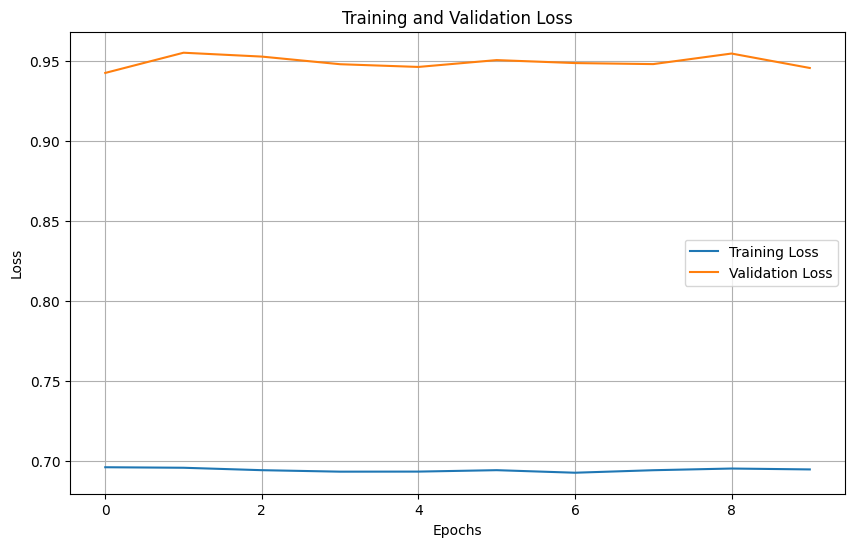

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plot saved and ready for download as 'training_validation_loss.png'


In [44]:

def plot_and_download_training_history(history, filename='training_history.png'):
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Saving the plot as an image
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    files.download(filename)
    print(f"Plot saved and ready for download as '{filename}'")

# Calling the function
plot_and_download_training_history(history, filename='training_validation_loss.png')


---
---

### MODEL 4: DONE BY MALAIKA AHMED (492471)
### DEC 31, 2024

---